<a href="https://colab.research.google.com/github/kkogggokk/TextClassification/blob/SY/preprocessing/baseline_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import requirements

In [ ]:
# restart the runtime after installing the following packages 
!pip install wandb
!pip install transformers 

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 139 kB 63.6 MB/s 
     |████████████████████████████████| 180 kB 74.6 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=5755d46bb8b6988907561263cc6099ef4692e627bc4e2f438c79cd6fa9a29568
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=605f26e8bbbf1d5dbb70ff8a07328c115358618a5d541755ef30fb2ceedd5fc5
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 56 kB 5.1 MB/s 
     |████████████████████████

In [ ]:
import os
import pdb
import wandb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict
import pandas as pd

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

# 1. Load data

In [ ]:
%cd "/content/drive/MyDrive/Competitions/Kaggle/Project1/data"
!pwd

/content/drive/MyDrive/Competitions/Kaggle/Project1/data
/content/drive/MyDrive/Competitions/Kaggle/Project1/data


In [ ]:
# !unzip goormtextclassificationproject.zip
# !ls .

In [ ]:
%cd .. 
!pwd

/content/drive/MyDrive/Competitions/Kaggle/Project1
/content/drive/MyDrive/Competitions/Kaggle/Project1


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Competitions/Kaggle/Project1/data"

In [ ]:
def load_data(file_name):
  data_strings = []
  with open(os.path.join(DATA_PATH, file_name), 'r', encoding='utf-8') as f:
    id_file_data = f.read().splitlines()
  return id_file_data

In [ ]:
train_pos_data = load_data("sentiment.train.1")
train_neg_data = load_data("sentiment.train.0")

dev_pos_data = load_data("sentiment.dev.1")
dev_neg_data = load_data("sentiment.dev.0")

In [ ]:
# make dataframes for EDA
train_pos_label = [1] * len(train_pos_data)
train_neg_label = [0] * len(train_neg_data)
train_df = pd.DataFrame({"text": train_pos_data + train_neg_data, "label": train_pos_label + train_neg_label})

dev_pos_label = [1] * len(dev_pos_data)
dev_neg_label = [0] * len(dev_neg_data)
dev_df = pd.DataFrame({"text": dev_pos_data + dev_neg_data, "label": dev_pos_label + dev_neg_label})

# 2. EDA

중복제거

In [ ]:
train_df.describe(include="all")

# _num_ -> frequency

,text,label
count,443259,443259.000000
unique,380570,NaN
top,_num_ .,NaN
freq,1608,NaN
mean,NaN,0.600193
std,NaN,0.489859
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [ ]:
# null 확인
train_df.isna().any()

text     False
label    False
dtype: bool

In [ ]:
# 아예 똑같은 값들 
train_df[train_df.duplicated()].sort_values('text')

,text,label
432062,!,0
390671,!,0
354148,!,0
182817,!,1
208706,!,1
...,...,...
385891,zero stars .,0
282555,zero stars .,0
316781,zero stars .,0
384516,zero stars if i could .,0


In [ ]:
# text 가 똑같은 애들 
train_df[train_df.duplicated(['text'], keep=False)].sort_values('text')

,text,label
72345,!,1
157927,!,1
322425,!,0
197444,!,1
435916,!,0
...,...,...
431665,zero stars .,0
318041,zero stars .,0
297580,zero stars if i could .,0
384516,zero stars if i could .,0


In [ ]:
# text 는 같지만 label 은 다른 애들
75643 - 62604

13039

In [ ]:
# 중복 제거
train_df_unique = train_df.drop_duplicates()

In [ ]:
train_df_unique

,text,label
0,excellent food .,1
1,superb customer service .,1
2,they also have daily specials and ice cream wh...,1
3,it 's a good toasted hoagie .,1
4,the staff is friendly .,1
...,...,...
443251,"they dont refill your drinks , which i always ...",0
443252,"service slow , pizza and wings were horrible .",0
443253,"zero stars , if i could give it .",0
443255,does n't stop by to see if you need anything .,0


In [ ]:
train_text_dup = train_df_unique[train_df_unique.duplicated(['text'], keep=False)].sort_values('text')
train_text_dup_indices = train_text_dup.index.tolist()

In [ ]:
# text 는 같지만 label이 달랐던 값들 제거
new_train_df = train_df_unique.drop(train_text_dup_indices)
new_train_df.index = range(len(new_train_df.index))

In [ ]:
new_train_df

,text,label
0,excellent food .,1
1,superb customer service .,1
2,they also have daily specials and ice cream wh...,1
3,it 's a good toasted hoagie .,1
4,the staff is friendly .,1
...,...,...
380480,"they dont refill your drinks , which i always ...",0
380481,"service slow , pizza and wings were horrible .",0
380482,"zero stars , if i could give it .",0
380483,does n't stop by to see if you need anything .,0


In [ ]:
new_train_df.describe(include="all")

,text,label
count,380485,380485.000000
unique,380485,NaN
top,the pricing is also good and keeps us coming b...,NaN
freq,1,NaN
mean,NaN,0.585540
std,NaN,0.492629
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


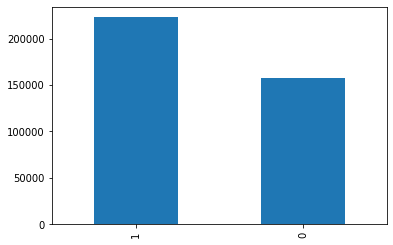

In [ ]:
new_train_df.label.value_counts().plot(kind="bar")

In [ ]:
dev_df.describe(include="all")

,text,label
count,4000,4000.000000
unique,3855,NaN
top,_num_ .,NaN
freq,25,NaN
mean,NaN,0.500000
std,NaN,0.500063
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.500000
75%,NaN,1.000000


In [ ]:
dev_df.isna().any()

text     False
label    False
dtype: bool

In [ ]:
# 아예 똑같은 값들 
dev_df[dev_df.duplicated()].sort_values('text')

,text,label
1389,!,1
2764,Negative,0
3172,Negative,0
1557,Neutral,1
3080,_num_ .,0
...,...,...
2298,wo n't be back .,0
1808,wow !,1
3797,wrong !,0
3075,wrong !,0


In [ ]:
# text 가 똑같은 애들 
dev_df[dev_df.duplicated(['text'], keep=False)].sort_values('text')

,text,label
80,!,1
1389,!,1
2764,Negative,0
3172,Negative,0
2338,Negative,0
...,...,...
3797,wrong !,0
3075,wrong !,0
2633,wrong !,0
1594,yeah !,1


In [ ]:
# text 는 같지만 label 은 다른 애들
223 - 143

80

In [ ]:
# 중복 제거
dev_df_unique = dev_df.drop_duplicates()

In [ ]:
dev_text_dup = dev_df_unique[dev_df_unique.duplicated(['text'], keep=False)].sort_values('text')
dev_text_dup_indices = dev_text_dup.index.tolist()

In [ ]:
# text 는 같지만 label이 달랐던 값들 제거
new_dev_df = dev_df_unique.drop(dev_text_dup_indices)
new_dev_df.index = range(len(new_dev_df.index))

In [ ]:
new_dev_df

,text,label
0,these donuts have the perfect texture and taste .,1
1,good food for the price .,1
2,"a little dirty on the inside , but wonderful p...",1
3,i always order it when i go there and it is al...,1
4,the rest of the food there is good also and no...,1
...,...,...
3848,i am sad to see how much this place has gone d...,0
3849,the food here is n't very good .,0
3850,it has n't been for quite a few years .,0
3851,the service the last time i went was just terr...,0


In [ ]:
new_dev_df.describe(include="all")

,text,label
count,3853,3853.000000
unique,3853,NaN
top,the chicken was dry and had no flavor .,NaN
freq,1,NaN
mean,NaN,0.499092
std,NaN,0.500064
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


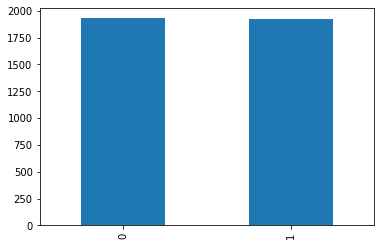

In [ ]:
new_dev_df.label.value_counts().plot(kind="bar")

# 3. Pre-process

In [ ]:
def tokenization(tokenizer, text_list):
  data_strings = []
  id_file_data = [tokenizer.encode(text.lower()) for text in text_list]
  for item in id_file_data:
    data_strings.append(' '.join([str(k) for k in item]))
  return data_strings

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [ ]:
train_pos_list = new_train_df[new_train_df['label'] == 1]["text"].tolist()
train_neg_list = new_train_df[new_train_df['label'] == 0]["text"].tolist()

dev_pos_list = new_dev_df[new_dev_df['label'] == 1]["text"].tolist()
dev_neg_list = new_dev_df[new_dev_df['label'] == 1]["text"].tolist()

In [ ]:
train_pos = tokenization(tokenizer, train_pos_list)
train_neg = tokenization(tokenizer, train_neg_list)

dev_pos = tokenization(tokenizer, dev_pos_list)
dev_neg = tokenization(tokenizer, dev_neg_list)

In [ ]:
train_pos[:10]

['101 6581 2833 1012 102',
 '101 21688 8013 2326 1012 102',
 '101 2027 2036 2031 3679 19247 1998 3256 6949 2029 2003 2428 2204 1012 102',
 '101 2009 1005 1055 1037 2204 15174 2098 7570 22974 2063 1012 102',
 '101 1996 3095 2003 5379 1012 102',
 '101 2204 3347 2833 1012 102',
 '101 2204 2326 1012 102',
 '101 11350 1997 2154 2003 25628 1998 7167 1997 19247 1012 102',
 '101 2307 2173 2005 6265 2030 3347 27962 1998 5404 1012 102',
 '101 1996 2047 2846 3504 6429 1012 102']